# Libraries

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
from plot import *

# Linear Regression in Numpy

In [7]:
true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))

#model: y = b + w x + epsilon
y = true_b + true_w * x + epsilon

# split data to train_test and Shuffle
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2,shuffle=True, random_state=42)


For now, we will be using batch gradient descent only, meaning, we’ll use all data
points for each one of the four steps above. It also means that going once through
all of the steps is already one epoch. Then, if we want to train our model over 1,000
epochs, we just need to add a single loop.

① Step 0: Random initialization of parameters / weights

② Initialization of hyper-parameters

③ Step 1: Forward pass

④ Step 2: Computing loss

⑤ Step 3: Computing gradients

⑥ Step 4: Updating parameters


In [8]:
# Step 0 - Initializes parameters "b" and "w" randomly
np.random.seed(42)
b = np.random.randn(1)
w = np.random.randn(1)

print(b, w)

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train
    
    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient
    # descent. How wrong is our model? That's the error!   
    error = (yhat - y_train)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Step 3 - Computes gradients for both "b" and "w" parameters
    b_grad = 2 * error.mean()
    w_grad = 2 * (x_train * error).mean()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate
    b = b - lr * b_grad
    w = w - lr * w_grad
    
print(b, w)

[0.49671415] [-0.1382643]
[1.01429206] [1.95986328]


point: There are ways of
stopping it earlier, once the progress is considered negligible (for instance, if the
loss was barely reduced). These are called, most appropriately, early stopping
methods.

In [9]:
# Sanity Check: do we get the same results as our
# gradient descent?
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[1.01429133] [1.95986473]


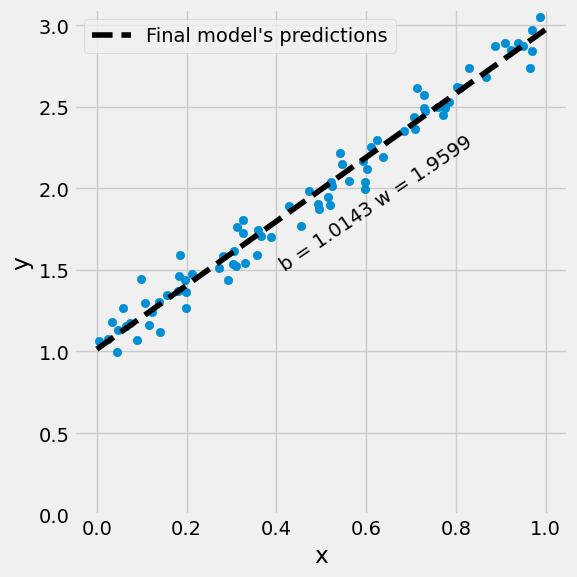

In [10]:
fig = figure3(x_train, y_train)

# PyTorch

## Tensor

**A scalar (a single number) has zero dimensions, a vector has one
dimension, a matrix has two dimensions, and a tensor has three
or more dimensions.**

But, to keep things simple, it is commonplace to call vectors and matrices tensors as
well—so, from now on, everything is either a scalar or a tensor.

In [15]:
scalar = torch.tensor(3.14159)
vector = torch.tensor([1, 2, 3])
matrix = torch.ones((2, 3), dtype=torch.float)
tensor = torch.randn((2, 3, 4), dtype=torch.float)

print(scalar)
print(vector)
print(matrix)
print(tensor)

tensor(3.1416)
tensor([1, 2, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[[ 1.2189, -0.7499,  1.1768,  0.1267],
         [ 1.1126, -1.0030, -0.5765, -0.2187],
         [-0.3212,  0.7264,  1.3247,  0.7378]],

        [[-0.4538,  1.2395, -1.8186, -0.2005],
         [ 0.0404, -0.4431,  2.4759,  0.9298],
         [ 0.8922,  1.6280, -0.8904,  1.8739]]])


In [16]:
print(tensor.size(), tensor.shape)

torch.Size([2, 3, 4]) torch.Size([2, 3, 4])


In [17]:
print(scalar.size(), scalar.shape)

torch.Size([]) torch.Size([])


You can also reshape a tensor using its view() (preferred) or reshape() methods.

Beware: The view() method only returns a tensor with the
desired shape that shares the underlying data with the original
tensor—it DOES NOT create a new, independent, tensor!
The reshape() method may or may not create a copy! 

In [18]:
# We get a tensor with a different shape but it still is
# the SAME tensor
same_matrix = matrix.view(1, 6)
# If we change one of its elements...
same_matrix[0, 1] = 2.
# It changes both variables: matrix and same_matrix
print(matrix)
print(same_matrix)

tensor([[1., 2., 1.],
        [1., 1., 1.]])
tensor([[1., 2., 1., 1., 1., 1.]])


If you want to copy all data, that is, duplicate the data in memory, you may use
either its new_tensor() or clone() methods.


In [20]:
# Lets follow PyTorch's suggestion and use "clone" method
another_matrix = matrix.view(1, 6).clone().detach()
# Again, if we change one of its elements...
another_matrix[0, 1] = 4.
# The original tensor (matrix) is left untouched!
print(matrix)
print(another_matrix)

tensor([[1., 2., 1.],
        [1., 1., 1.]])
tensor([[1., 4., 1., 1., 1., 1.]])


## Loading Data, Devices and CUDA

It is time to start converting our Numpy code to PyTorch: We’ll start with the
training data; that is, our x_train and y_train arrays.

In [21]:
x_train_tensor = torch.as_tensor(x_train)
x_train.dtype, x_train_tensor.dtype

(dtype('float64'), torch.float64)

In [22]:
float_tensor = x_train_tensor.float()
float_tensor.dtype

torch.float32

### Defining your device

So far, we have only created CPU tensors. What does it mean? It means the data in
the tensor is stored in the computer’s main memory and any operations performed
on it are going to be handled by its CPU. So, although the data is, technically speaking, in the
memory, we’re still calling this kind of tensor a CPU tensor.

There is also a GPU tensor. A GPU ) is the processor of a graphics card. These tensors store their data in the graphics card’s memory, and operations on top of them are performed by the GPU.

If you have a graphics card from NVIDIA, you can use the power of its GPU to
speed up model training. PyTorch supports the use of these GPUs for model
training using CUDA (Compute Unified Device Architecture), which needs to be
previously installed and configured.

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

To know how many GPUs it
has, or which model they are, you can figure it out using cuda.device_count() and
cuda.get_device_name():


In [13]:
n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

NVIDIA GeForce MX150


turn our tensor into a GPU tensor

In [14]:
gpu_tensor = torch.as_tensor(x_train).to(device)
gpu_tensor[0]

tensor([0.9219], device='cuda:0', dtype=torch.float64)

### Cell 1.3

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

So, we defined a device, converted both Numpy arrays into PyTorch tensors, cast
them to floats, and sent them to the device. Let’s take a look at the types:


In [16]:
# Here we can see the difference - notice that .type() is more
# useful since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


## Creating Parameters

The latter requires the computation of its gradients, so we can update their values
(the parameters’ values, that is). That’s what the requires_grad=True argument is
good for. It tells PyTorch to compute gradients for us.

The first chunk of code below creates two tensors for our parameters, including
gradients and all. But they are CPU tensors, by default.

In [18]:
# FIRST
# Initializes parameters "b" and "w" randomly, ALMOST as we
# did in Numpy since we want to apply gradient descent on
# these parameters we need to set REQUIRES_GRAD = TRUE
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
w = torch.randn(1, requires_grad=True, dtype=torch.float)
print(b, w)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


I am assuming you’d like to use your GPU (or the one from Google Colab), right? So
we need to send those tensors to the device. We can try the naive approach, the
one that worked well for sending the training data to the device. That’s our second
(and failed) attempt:

In [17]:
# SECOND
# But what if we want to run it on a GPU? We could just
# send them to device, right?
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
w = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(b, w)
# Sorry, but NO! The to(device) "shadows" the gradient...

tensor([0.3367], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([0.1288], device='cuda:0', grad_fn=<ToCopyBackward0>)


We succeeded in sending them to another device, but we "lost" the gradients
somehow, since there is no more requires_grad=True

In the third chunk, we first send our tensors to the device and then use the
requires_grad_() method to set its requires_grad attribute to True in place.


In [19]:
# THIRD
# We can either create regular tensors and send them to
# the device (as we did with our data)
torch.manual_seed(42)
b = torch.randn(1, dtype=torch.float).to(device)
w = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
b.requires_grad_()
w.requires_grad_()
print(b, w)

tensor([0.3367], device='cuda:0', requires_grad=True) tensor([0.1288], device='cuda:0', requires_grad=True)


we can do better: We can assign tensors to a device at the moment of their
creation.

In [20]:
# FINAL
# We can specify the device at the moment of creation
# RECOMMENDED!

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
print(b, w)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


# Autograd

Autograd is PyTorch’s automatic differentiation package. Thanks to it, we don’t need
to worry about partial derivatives, chain rule, or anything like it.

## backward

 It will compute gradients for all (gradient-requiring)
tensors involved in the computation of a given variable.
Do you remember the starting point for computing the gradients? It was the loss,
as we computed its partial derivatives w.r.t. our parameters. Hence, we need to
invoke the backward() method 

In [36]:
# Step 1 - Computes our model's predicted output - forward pass
yhat = b + w * x_train_tensor

# Step 2 - Computes the loss
# We are using ALL data points, so this is BATCH gradient descent
# How wrong is our model? That's the error! 
error = (yhat - y_train_tensor)
# It is a regression, so it computes mean squared error (MSE)
loss = (error ** 2).mean()

# Step 3 - Computes gradients for both "b" and "w" parameters
# No more manual computation of gradients! 
# b_grad = 2 * error.mean()
# w_grad = 2 * (x_tensor * error).mean()
loss.backward()

Which tensors are going to be handled by the backward() method applied to the
loss?

• b

• w

• yhat

• error

We have set requires_grad=True to both b and w, so they are obviously included in
the list. We use them both to compute yhat, so it will also make it to the list. Then
we use yhat to compute the error, which is also added to the list.

Do you see the pattern here? If a tensor in the list is used to compute another
tensor, the latter will also be included in the list. Tracking these dependencies is
exactly what the dynamic computation graph is doing, as we’ll see shortly.

What about x_train_tensor and y_train_tensor? They are involved in the
computation too, but we created them as non-gradient-requiring tensors, so
backward() does not care about them.

In [37]:
print(error.requires_grad, yhat.requires_grad, \
      b.requires_grad, w.requires_grad)
print(y_train_tensor.requires_grad, x_train_tensor.requires_grad)

True True True True
False False


## zero_

Every time we use the gradients to update the parameters, we need to zero the
gradients afterward. And that’s what zero_() is good for.


In [39]:
# This code will be placed *after* Step 4
# (updating the parameters)
b.grad.zero_(), w.grad.zero_()

(tensor([0.]), tensor([0.]))

## Updating Parameters

In [40]:
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient
    # descent. How wrong is our model? That's the error!
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both "b" and "w" parameters
    # No more manual computation of gradients! 
    # b_grad = 2 * error.mean()
    # w_grad = 2 * (x_tensor * error).mean()   
    # We just tell PyTorch to work its way BACKWARDS 
    # from the specified loss!
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate. But not so fast...
    # FIRST ATTEMPT - just using the same code as before
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # b = b - lr * b.grad
    # w = w - lr * w.grad
    # print(b)

    # SECOND ATTEMPT - using in-place Python assigment
    # RuntimeError: a leaf Variable that requires grad
    # has been used in an in-place operation.
    # b -= lr * b.grad
    # w -= lr * w.grad        
    
    # THIRD ATTEMPT - NO_GRAD for the win!
    # We need to use NO_GRAD to keep the update out of
    # the gradient computation. Why is that? It boils 
    # down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        b -= lr * b.grad
        w -= lr * w.grad
    
    # PyTorch is "clingy" to its computed gradients, we
    # need to tell it to let it go...
    b.grad.zero_()
    w.grad.zero_()
    
print(b, w)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## no_grad

### This is what we used in the THIRD ATTEMPT...

# Dynamic Computation Graph

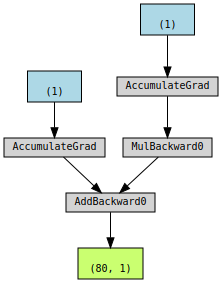

In [21]:
# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Step 1 - Computes our model's predicted output - forward pass
yhat = b + w * x_train_tensor

# Step 2 - Computes the loss
# We are using ALL data points, so this is BATCH gradient
# descent. How wrong is our model? That's the error! 
error = (yhat - y_train_tensor)
# It is a regression, so it computes mean squared error (MSE)
loss = (error ** 2).mean()

# We can try plotting the graph for any python variable: 
# yhat, error, loss...
make_dot(yhat)

Let’s take a closer look at its components:

• blue boxes ((1)s): these boxes correspond to the tensors we use as
parameters, the ones we’re asking PyTorch to compute gradients for

• gray boxes (MulBackward0 and AddBackward0): Python operations that involve
gradient-computing tensors or its dependencies

• green box ((80, 1)): the tensor used as the starting point for the computation
of gradients (assuming the backward() method is called from the variable used
to visualize the graph)—they are computed from the bottom-up in a graph


# Optimizer

So far, we’ve been manually updating the parameters using the computed
gradients. That’s probably fine for two parameters, but what if we had a whole lot
of them? We need to use one of PyTorch’s optimizers, like SGD, RMSprop, or
Adam.

There are many optimizers: SGD is the most basic of them, and
Adam is one of the most popular.

Different optimizers use different mechanics for updating the
parameters, but they all achieve the same goal through, literally,
different paths.

Remember, the choice of mini-batch size influences the path of
gradient descent, and so does the choice of an optimizer.

## step / zero_grad

An optimizer takes the parameters we want to update, the learning rate we want
to use (and possibly many other hyper-parameters as well!), and performs the
updates through its step() method.

An optimizer takes the parameters we want to update, the learning rate we want
to use (and possibly many other hyper-parameters as well!).

Besides, we also don’t need to zero the gradients one by one anymore. We just
invoke the optimizer’s zero_grad() method, and that’s it!

In the code below, we create a stochastic gradient descent (SGD) optimizer to update
our parameters b and w.


In [23]:
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient 
    # descent. How wrong is our model? That's the error! 
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate. No more manual update!
    # with torch.no_grad():
    #     b -= lr * b.grad
    #     w -= lr * w.grad
    optimizer.step()
    
    # No more telling Pytorch to let gradients go!
    # b.grad.zero_()
    # w.grad.zero_()
    optimizer.zero_grad()
    
print(b, w)

tensor([1.0143], device='cuda:0', requires_grad=True) tensor([1.9599], device='cuda:0', requires_grad=True)


# Loss

We now tackle the loss computation. As expected, PyTorch has us covered once
again. There are many loss functions to choose from, depending on the task at
hand. 

Since ours is a regression, we are using the mean squared error (MSE) as loss,
and thus we need PyTorch’s nn.MSELoss()

In [47]:
# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')
loss_fn

MSELoss()

Notice that nn.MSELoss() is NOT the loss function itself: We do not pass
predictions and labels to it! Instead, as you can see, it returns another function,
which we called loss_fn: That is the actual loss function. So, we can pass a
prediction and a label to it and get the corresponding loss value:


In [24]:
# Sets learning rate - this is "eta" ~ the "n"-like
# Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 - Computes the loss
    # No more manual loss!
    # error = (yhat - y_train_tensor)
    # loss = (error ** 2).mean()
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()
    
print(b, w)

tensor([1.0143], device='cuda:0', requires_grad=True) tensor([1.9599], device='cuda:0', requires_grad=True)


In [25]:
loss

tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

# Model

In [26]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "b" and "w" real parameters of the model,
        # we need to wrap them with nn.Parameter
        self.b = nn.Parameter(torch.randn(1,
                                          requires_grad=True, 
                                          dtype=torch.float))
        self.w = nn.Parameter(torch.randn(1, 
                                          requires_grad=True,
                                          dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.b + self.w * x

In [27]:
# Sets learning rate - this is "eta" ~ the "n"-like
# Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    model.train() # What is this?!?

    # Step 1 - Computes model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor)
    
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()
    
# We can also inspect its parameters using its state_dict
print(model.state_dict())

OrderedDict([('b', tensor([1.0143], device='cuda:0')), ('w', tensor([1.9599], device='cuda:0'))])


## Nested Models

In [64]:
class MyLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear model
        # with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call
        self.linear(x)

In [65]:
torch.manual_seed(42)
dummy = MyLinearRegression().to(device)
list(dummy.parameters())

[Parameter containing:
 tensor([[0.7645]], device='cuda:0', requires_grad=True), Parameter containing:
 tensor([0.8300], device='cuda:0', requires_grad=True)]

In [66]:
dummy.state_dict()

OrderedDict([('linear.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear.bias', tensor([0.8300], device='cuda:0'))])

## Sequential Models

For straightforward models that use a series of built-in PyTorch models (like
Linear), where the output of one is sequentially fed as an input to the next, we can
use a, er … Sequential model.

In our case, we would build a sequential model with a single argument; that is, the
Linear model we used to train our linear regression.

We’ve been talking about models inside other models. This may get confusing real
quick, so let’s follow convention and call any internal model a layer.

## Layers

A Linear model can be seen as a layer in a neural network.


In [68]:
torch.manual_seed(42)
# Building the model from the figure above
model = nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 1)).to(device)

model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.4414,  0.4792, -0.1353],
                      [ 0.5304, -0.1265,  0.1165],
                      [-0.2811,  0.3391,  0.5090],
                      [-0.4236,  0.5018,  0.1081],
                      [ 0.4266,  0.0782,  0.2784]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0815,  0.4451,  0.0853, -0.2695,  0.1472], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2060, -0.0524, -0.1816,  0.2967, -0.3530]], device='cuda:0')),
             ('1.bias', tensor([-0.2062], device='cuda:0'))])

In [69]:
torch.manual_seed(42)
# Building the model from the figure above
model = nn.Sequential()
model.add_module('layer1', nn.Linear(3, 5))
model.add_module('layer2', nn.Linear(5, 1))
model.to(device)

Sequential(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

There are MANY different layers that can be used in PyTorch:

• Convolution Layers

• Pooling Layers

• Padding Layers

• Non-linear Activations

• Normalization Layers

• Recurrent Layers

• Transformer Layers

• Linear Layers

• Dropout Layers

• Sparse Layers (embeddings)

• Vision Layers

• DataParallel Layers (multi-GPU)

• Flatten Layer

# Putting It All Together

It is time to put it all together and organize our code into three fundamental parts,
namely:

• data preparation (not data generation!)

• model configuration

• model training


## Data Preparation

In [30]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them
# into PyTorch's Tensors and then we send them to the 
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

## Model Configurtion

In [31]:

# This is redundant now, but it won't be when we introduce
# Datasets...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

## Model Training

In [32]:

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - Computes model's predicted output - forward pass
    yhat = model(x_train_tensor)
    
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()

In [33]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9599]], device='cuda:0')), ('0.bias', tensor([1.0143], device='cuda:0'))])
